# Data Exploration
Before I get to attempting to model when to "shake it up." I need to look at, and better understand my data.

Let's dive in!

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [141]:
df = pd.read_pickle("data/InitialFeatures.pkl")

## Number of Times Lines Were "Shaked Up"
First, I want to know how many times does the top lines change from one game to the next.

In [125]:
len(df.loc[df["Away L1 Shuffled"] == True]) + len(df.loc[df["Home L1 Shuffled"] == True])

796

But we don't want to include injuries, so let's do:

In [126]:
NSwitches = len(df.loc[(df["Home L1 Shuffled"] == True) & (df["Home L1 Injury"] == False)]) + \
                len(df.loc[(df["Away L1 Shuffled"] == True) & (df["Away L1 Injury"] == False)])
print(NSwitches)
Nopps = len(df)*2
print(Nopps)
print("The top line is changed on average {0:5.2f}% of the time".format(NSwitches/Nopps*100))

646
2460
The top line is changed on average 26.26% of the time


The top line is actually changed more than I expected. That's interesting.

## Does the rate of change depend on win percentage?

Let's add another row to the dataframe to hold win percentage.

In [143]:

win_bin_edges = np.linspace(0.,1.,num=11)
def calc_WLp(wins,losses):
    if wins + losses == 0:
        retval = 0
    else:
        retval = wins/(wins + losses)
    return retval
df['Away W frac'] = df.apply(lambda row: calc_WLp(row['Away Wins'],row['Away Losses']), axis=1)
df['Home W frac'] = df.apply(lambda row: calc_WLp(row['Home Wins'],row['Home Losses']), axis=1)


Now, for each win percentage bin let's calculate: 

2) number of games that teams changed their top line

1) number of games that teams did not changed their top line

In [129]:
N_chg  = np.zeros(len(win_bin_edges)-1)
N_stay = np.zeros(len(win_bin_edges)-1)
for i in range(len(df)):
    for loc in ("Away","Home"):
        for j in range(1,len(win_bin_edges)):
            if win_bin_edges[j] > df['{0} W frac'.format(loc)].iloc[i]:
                if (df['{0} L1 Shuffled'.format(loc)].iloc[i] and 
                    not df['{0} L1 Injury'.format(loc)].iloc[i]):
                    N_chg[j-1] += 1
                else:
                    N_stay[j-1] += 1
                break
                    

Below are a few functions that I actually wrote/borrowed for my research a few years ago - so sorry about the lack of comments. These functions will calculate the 95% error bars for a "fractional" bar graph.

In [132]:
def choose(n, k):
    """
    A fast way to calculate binomial coefficients by Andrew Dalke.
    """
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0
def binomial_uncert(n1,n2,bins):
   # Uncertainties
    F = [0]*len(n1)
    xc = [0]*len(n1)
    n = [0]*len(n1)
    for i in range(len(n1)):
        if n1[i] + n2[i] == 0:
            F[i] = 0
        else: 
            F[i] = float(n2[i])/(float(n1[i])+float(n2[i]))
        xc[i] = (bins[i]+bins[i+1])/2.
        n[i] = n1[i]+n2[i]
    upper = [0]*len(n1)
    lower = [0]*len(n1)

    for i in range(len(F)):
        # upper uncertainty
        Pr = 1
        ming = F[i]
        maxg = 1.
        while abs(Pr-0.025) > 0.0001:
            p = (maxg+ming)/2. 
            Pr = float(choose(int(n[i]), int(n2[i])))*p**n2[i]*(1.-p)**(n[i]-n2[i])
            if Pr > 0.025:
                ming = p
            else:
                maxg = p
            if Pr == 1.:
                break
        upper[i] = p-F[i]
        # lower uncertainty
        Pr = 1
        ming = 0
        maxg = F[i]
        while abs(Pr-0.025) > 0.0001:
            p = (maxg+ming)/2.
            Pr = float(choose(int(n[i]), int(n2[i])))*p**n2[i]*(1.-p)**(n[i]-n2[i])
            if Pr < 0.025:
                ming = p
            else:
                maxg = p
            if Pr == 1.:
                break
        lower[i] = F[i]-p
    return xc,upper,lower

In [133]:
# Let's find those errors
xc,upper,lower = binomial_uncert(N_stay,N_chg,win_bin_edges)


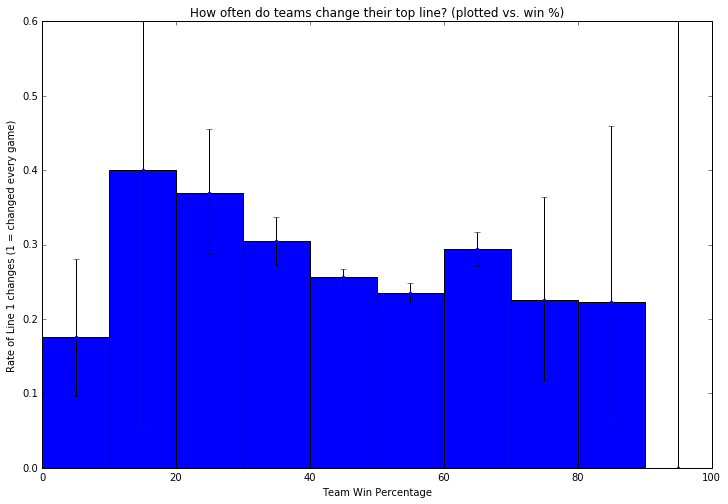

In [146]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.bar(win_bin_edges[:-1]*100,N_chg/(N_chg+N_stay),align='edge',width=10)
ax.errorbar(np.array(xc)*100,N_chg/(N_chg+N_stay),yerr=[lower,upper],fmt='.',ecolor='k')
ax.set_xlim(0,100)
ax.set_ylim(0.,.6)
ax.set_xlabel("Team Win Percentage")
ax.set_ylabel("Rate of Line 1 changes (1 = changed every game)")
ax.set_title("How often do teams change their top line? (plotted vs. win %)")
plt.savefig("Win_perc_rate.png")
plt.show()
plt.clf()

(In a rough sense) teams that are not winning as much change their top line more often. It seems very reasonable that a top line that is not scoring (or defending well) would be changed more often.

## Do teams typically do better after "shaking it up?"
Here I am going to look at the win % after a team has changed their top line compared to their win % when they don't change their top line. Does it make a difference in general? Do certain teams do it better than others?

In [147]:
teams = df["Home Team"].unique()

In [99]:
dic_chg_v_ng = {}
dic_chg = {}
dic_nchg = {} 
i = 0
for team in teams:
    N_shuf_win = len(df.loc[((df['Away Team'] == team) & (df['Away L1 Shuffled'] == True) & (df['Away L1 Injury'] == False) 
                     & (df['Away Score'] > df['Home Score'])) | 
           ((df['Home Team'] == team) & (df['Home L1 Shuffled'] == True) & (df['Home L1 Injury'] == False)
                     & (df['Home Score'] > df['Away Score']))])

    N_shuf_loss = len(df.loc[((df['Away Team'] == team) & (df['Away L1 Shuffled'] == True) & (df['Away L1 Injury'] == False) 
                     & (df['Away Score'] < df['Home Score'])) | 
           ((df['Home Team'] == team) & (df['Home L1 Shuffled'] == True) & (df['Home L1 Injury'] == False)
                     & (df['Home Score'] < df['Away Score']))])

    N_noshuf_win = len(df.loc[((df['Away Team'] == team) & (df['Away L1 Shuffled'] == False)
                     & (df['Away Score'] > df['Home Score'])) | 
           ((df['Home Team'] == team) & (df['Home L1 Shuffled'] == False)
                     & (df['Home Score'] > df['Away Score']))])

    N_noshuf_loss = len(df.loc[((df['Away Team'] == team) & (df['Away L1 Shuffled'] == False) 
                     & (df['Away Score'] < df['Home Score'])) | 
           ((df['Home Team'] == team) & (df['Home L1 Shuffled'] == False) 
                     & (df['Home Score'] < df['Away Score']))])

    # For sanity purposes I calculate the number of times line 1 is shuffled due to injury also ...
    N_shuf_inj = len(
           df.loc[((df['Away Team'] == team) & (df['Away L1 Shuffled'] == True) & (df['Away L1 Injury'] == True)) | 
           ((df['Home Team'] == team) & (df['Home L1 Shuffled'] == True) & (df['Home L1 Injury'] == True))])
    # ... so I can make sure every team plays 82 games
    assert  N_shuf_win+N_shuf_loss+N_noshuf_win+N_noshuf_loss+N_shuf_inj == 82

    dic_chg[team+" win"] = N_shuf_win
    dic_chg[team+" loss"] = N_shuf_loss
    dic_nchg[team+" win"] = N_noshuf_win
    dic_nchg[team+" loss"] = N_noshuf_loss
    dic_chg_v_ng[team] = N_shuf_win/(N_shuf_win+N_shuf_loss) - N_noshuf_win/(N_noshuf_win+N_noshuf_loss)
    i += 1

Let's order this by the teams' season win percentage

In [100]:
dict_team_wp = {}
for team in teams:
    end_row = df.loc[((df['Away Team'] == team) | (df['Home Team'] == team))].iloc[-1]
    if end_row['Away Team'] == team:
        dict_team_wp[team] = end_row['Away W frac']
    else: 
        dict_team_wp[team] = end_row['Home W frac']

sorted_teams = sorted(dict_team_wp, key=dict_team_wp.get)




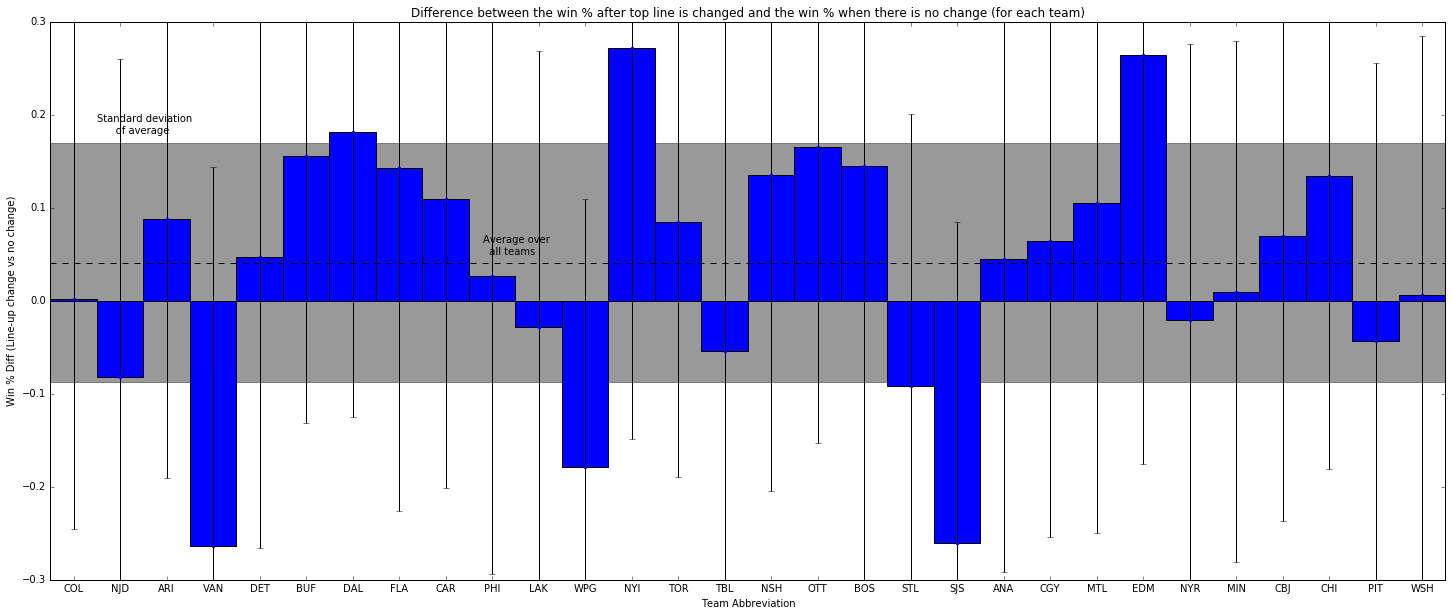

In [150]:
# Build an array (because it's ordered) to use in the bar plot
ar_chg_v_ng = np.empty(len(sorted_teams),dtype="U3,f")
ar_chg = np.zeros((len(sorted_teams),2))
ar_nchg = np.zeros((len(sorted_teams),2))
for i in range(len(sorted_teams)):
    ar_chg_v_ng[i][0] = sorted_teams[i]
    ar_chg_v_ng[i][1] = dic_chg_v_ng[sorted_teams[i]]
    ar_chg[i,0]  = dic_chg[sorted_teams[i]+" win"] 
    ar_chg[i,1]  = dic_chg[sorted_teams[i]+" loss"] 
    ar_nchg[i,0] = dic_nchg[sorted_teams[i]+" win"] 
    ar_nchg[i,1] = dic_nchg[sorted_teams[i]+" loss"] 

# Find Error bars
xc_chg,upper_chg,lower_chg = binomial_uncert(ar_chg[:,1],ar_chg[:,0],range(len(ar_chg_v_ng)+1))
xc_nchg,upper_nchg,lower_nchg = binomial_uncert(ar_nchg[:,1],ar_nchg[:,0],range(len(ar_chg_v_ng)+1))

assert xc_chg == xc_nchg

# Add the uncertainties together
upper = np.array(upper_chg) + np.array(upper_nchg)
lower = np.array(lower_chg) + np.array(lower_nchg)

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
ax.fill_between((-0.5,29.5),(np.mean(ar_chg_v_ng['f1'])-np.std(ar_chg_v_ng['f1']),
                             np.mean(ar_chg_v_ng['f1'])-np.std(ar_chg_v_ng['f1'])),
                            (np.mean(ar_chg_v_ng['f1'])+np.std(ar_chg_v_ng['f1']),
                             np.mean(ar_chg_v_ng['f1'])+np.std(ar_chg_v_ng['f1'])),facecolor='k',alpha=.4)
ax.plot((-0.5,29.5),(np.mean(ar_chg_v_ng['f1']),np.mean(ar_chg_v_ng['f1'])),'k--',linewidth=1)
ax.text(8.8,.05,"Average over\n  all teams")
ax.text(.5,.18,"Standard deviation\n      of average")
ax.bar(range(len(ar_chg_v_ng)), ar_chg_v_ng['f1'], width=1, align='center')

ax.errorbar(range(len(ar_chg_v_ng)),ar_chg_v_ng['f1'],yerr=[lower,upper],fmt='.',ecolor='k')
xtics = plt.xticks(range(len(ar_chg_v_ng)), list(ar_chg_v_ng['f0']))
ax.set_xlim(-0.5,29.5)
ax.set_ylim(-.3,.3)
plt.title("Difference between the win % after top line is changed and the win % when there is no change (for each team)")
ax.set_xlabel("Team Abbreviation")
ax.set_ylabel("Win % Diff (Line-up change vs no change)")
plt.savefig("Win_per_diff.png")


## Previous Exploration
This is previous data exploration that I have kept here because I might use some of this code in the future. Proceed a your own risk!


## Number of Times Lines Were "Shaked UP"
First, I want to know how many times does one of the top two lines change from one game to the next.

In [3]:
len(df.loc[df["Away L12 Shuffled"] == True]) + len(df.loc[df["Home L12 Shuffled"] == True])

1202

But we don't want to include injuries, so let's do:

In [4]:
NSwitches = len(df.loc[(df["Home L12 Shuffled"] == True) & (df["Home L12 Injury"] == False)]) + \
                len(df.loc[(df["Away L12 Shuffled"] == True) & (df["Away L12 Injury"] == False)])
print(NSwitches)
Nopps = len(df)*2
print(Nopps)
print("The top 2 lines are changed on average {0:5.2f}% of the time".format(NSwitches/Nopps*100))

852
2460
The top 2 lines are changed on average 34.63% of the time


## When in the Season Do Teams "Shake It Up?"?

In [5]:
df['Date'].iat[0][5:7]
shdates = df.loc[(df["Home L12 Shuffled"] == True) & (df["Home L12 Injury"] == False)]['Date']
sadates = df.loc[(df["Away L12 Shuffled"] == True) & (df["Away L12 Injury"] == False)]['Date']
sdates = pd.concat([shdates,sadates])
alldates = pd.concat([df['Date'],df['Date']])
dtm = lambda x: int(x[5:7])
smonths = list(map(dtm, sdates))
amonths = list(map(dtm, alldates))
bins = np.arange(1,14)
ns, b_edges = np.histogram(smonths, bins=bins)
na, b_edges = np.histogram(amonths, bins=bins)
frac = [0]*len(na)
for i in range(len(na)):
    if na[i] != 0:
        frac[i] = ns[i]/na[i]
xticklabels = [datetime.date(1900,i,1).strftime('%b') for i in bins[9:-1]] + [datetime.date(1900,i,1).strftime('%b') for i in bins[:4]]
fracplt = frac[-3:] + frac[:4]

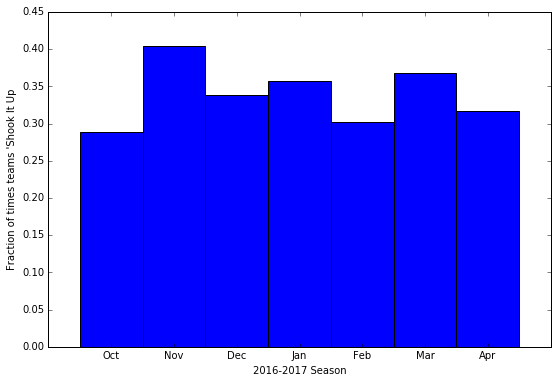

In [6]:
## Plot it
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
ax.bar(range(1,8),fracplt, align='center',width=1)
ax.set_xticks(range(1,8))
ax.set_xticklabels(xticklabels)
ax.set_ylabel("Fraction of times teams 'Shook It Up")
ax.set_xlabel("2016-2017 Season")
plt.show()


Seams to be fairly consistent throughout the season for the NHL on a whole. What about one team?


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e7a798438>
0
Axes(0.125,0.547727;0.352273x0.352273)
[0.3333333333333333, 0.35714285714285715, 0.5, 0.46153846153846156, 0.5833333333333334, 0.26666666666666666, 0.2]
1
Axes(0.547727,0.547727;0.352273x0.352273)
[0.1111111111111111, 0.3333333333333333, 0.14285714285714285, 0.38461538461538464, 0.5, 0.13333333333333333, 0.3333333333333333]
2
Axes(0.125,0.125;0.352273x0.352273)
[0.5, 0.6, 0.46153846153846156, 0.4166666666666667, 0.3076923076923077, 0.4, 0.0]
3
Axes(0.547727,0.125;0.352273x0.352273)
[0.5555555555555556, 0.2857142857142857, 0.26666666666666666, 0.18181818181818182, 0.5, 0.4375, 0.0]


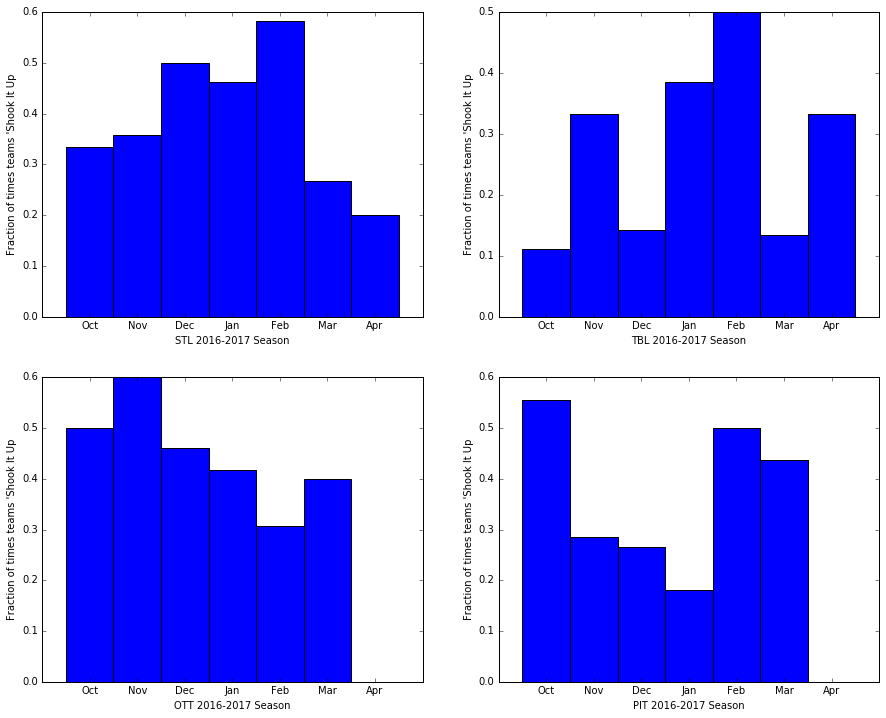

In [7]:
teams = ("STL","TBL","OTT","PIT")
fig, axs = plt.subplots(2,2,figsize=(15,12))
print(axs)
for j in range(len(teams)):
    print(j)
    ax = axs[j//2][j%2]
    print(ax)
    shdates = df.loc[(df["Home Team"] == teams[j]) & (df["Home L12 Shuffled"] == True) & (df["Home L12 Injury"] == False)]['Date']
    sadates = df.loc[(df["Away Team"] == teams[j]) & (df["Away L12 Shuffled"] == True) & (df["Away L12 Injury"] == False)]['Date']
    sdates = pd.concat([shdates,sadates])
    alldates = pd.concat((df.loc[(df["Away Team"] == teams[j])]['Date'],df.loc[(df["Home Team"] == teams[j])]['Date']))
    dtm = lambda x: int(x[5:7])
    smonths = list(map(dtm, sdates))
    amonths = list(map(dtm, alldates))
    bins = np.arange(1,14)
    ns, b_edges = np.histogram(smonths, bins=bins)
    na, b_edges = np.histogram(amonths, bins=bins)
    frac = [0]*len(na)
    for i in range(len(na)):
        if na[i] != 0:
            frac[i] = ns[i]/na[i]
    xticklabels = [datetime.date(1900,i,1).strftime('%b') for i in bins[9:-1]] + [datetime.date(1900,i,1).strftime('%b') for i in bins[:4]]
    fracplt = frac[-3:] + frac[:4]
    ## Plot it
    print(fracplt)
    ax.bar(range(1,8),fracplt, align='center',width=1)
    ax.set_xticks(range(1,8))
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel("Fraction of times teams 'Shook It Up")
    ax.set_xlabel("{0} 2016-2017 Season".format(teams[j]))
plt.show()

For each individual team, the number of shake ups varies throughout the season. 

In [8]:
print(df.columns)

Index(['Home Team', 'Away Score', 'Home Score', 'Away W/L Streak',
       'Home W/L Streak', 'Away Wins', 'Home Wins', 'Away Losses',
       'Home Losses', 'Away L12 Shuffled', 'Home L12 Shuffled',
       'Away L12 Injury', 'Home L12 Injury', 'Away Scored Goals p1',
       'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10', 'Date', 'Away Team'],
      dtype='object')


In [9]:
df_s = df.loc[(df["Home L12 Shuffled"] == True) & (df["Home L12 Injury"] == False) |
              (df["Away L12 Shuffled"] == True) & (df["Away L12 Injury"] == False)]
cols = ['Away Score', 'Home Score', 'Away W/L Streak',
       'Home W/L Streak', 'Away Wins', 'Home Wins', 'Away Losses',
       'Home Losses', 
       'Away Scored Goals p1',
       'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10']

df_s = df_s[cols]
df_s["Away Win?"] = df_s.apply(lambda row: int(row['Away Score'] > row['Home Score']), axis=1)
df_s["Home Win?"] = df_s.apply(lambda row: int(row['Away Score'] < row['Home Score']), axis=1)
def AWin_Per(row):
    if row['Away Wins'] == 0:
        return 0.
    else:
        return float(row['Away Wins'])/float(row['Away Wins']+row['Away Losses'])*100
def HWin_Per(row):
    if row['Home Wins'] == 0:
        return 0.
    else:
        return float(row['Home Wins'])/float(row['Home Wins']+row['Home Losses'])*100
df_s["Away Win %"] = df_s.apply(AWin_Per, axis=1)
df_s["Home Win %"] = df_s.apply(HWin_Per, axis=1)

#pd.plotting.scatter_matrix(df_s, alpha = 0.3, figsize = (28,36), diagonal = 'kde');

In [10]:
df_s.columns



Index(['Away Score', 'Home Score', 'Away W/L Streak', 'Home W/L Streak',
       'Away Wins', 'Home Wins', 'Away Losses', 'Home Losses',
       'Away Scored Goals p1', 'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10', 'Away Win?', 'Home Win?', 'Away Win %',
       'Home Win %'],
      dtype='object')

'Away Scored Goals p1',
       'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10'

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
print(df_s.columns)
# Split-out validation dataset
X = df_s.drop(['Away Win?', 'Home Win?',"Away Score","Home Score"], axis=1)
Y = df_s["Home Win?"]
validation_size = 0.20
seed = 242345567
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)



model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=1, random_state=seed)
# Fit the model to the data.
model.fit(X_train,Y_train)
# Make predictions.
predictions = model.predict(X_validation)
#print(Y_validation)
# Compute the error.
err = np.zeros(len(predictions))
for i in range(len(err)):
    err[i] = abs(predictions[i]-Y_validation.iat[i])
print("RForest Mean Error   = {0}".format(np.mean(err)))
print("RForest Median Error = {0}".format(np.median(err)))


model = LinearRegression()
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
print(df_s.columns,model.coef_)
#print("Intercept: {0}".format(model.intercept_))
#for i in range(len(X[0,:])):
    #print("Coeffient: {0} = {1}".format(dataset.columns[i],model.coef_[i]))

# Compute the error.
err = np.zeros(len(predictions))
for i in range(len(err)):
    print(predictions[i])
    err[i] = abs(predictions[i]-Y_validation.iat[i])

print("Linear Mean Error   = {0}".format(np.mean(err)))
print("Linear Median Error = {0}".format(np.median(err)))



Index(['Away Score', 'Home Score', 'Away W/L Streak', 'Home W/L Streak',
       'Away Wins', 'Home Wins', 'Away Losses', 'Home Losses',
       'Away Scored Goals p1', 'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10', 'Away Win?', 'Home Win?', 'Away Win %',
       'Home Win %'],
      dtype='object')
RForest Mean Error   = 0.48824822695035464
RForest Median Error = 0.491
Index(['Away Score', 'Home Score', 'Away W/L Streak', 'Home W/L Streak',
       'Away Wins', 'Home Wins', 'Away Losses', 'Home Losses',
       'Away Scored Goals p1', 'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Go

In [13]:
X.columns

Index(['Away W/L Streak', 'Home W/L Streak', 'Away Wins', 'Home Wins',
       'Away Losses', 'Home Losses', 'Away Scored Goals p1',
       'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10', 'Away Win %', 'Home Win %'],
      dtype='object')

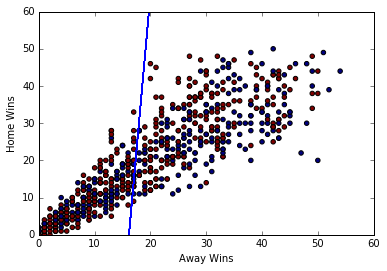

In [62]:
plt.scatter(X2['Away Wins'],X2['Home Wins'],c=Y)
plt.xlabel("Away Wins")
plt.ylabel("Home Wins")
plt.plot(X2['Away Wins'],(model.intercept_ - .5 + model.coef_[0]*X2['Away Wins'])/(-model.coef_[1]),label="Linear Reg. Decison Boundary")
plt.axis([0,60,0,60])
plt.show()

In [97]:
from sklearn.linear_model import LogisticRegression
# Split-out validation dataset
X = df_s.drop(['Away Win?', 'Home Win?',"Away Score","Home Score"], axis=1)
Y = df_s["Home Win?"]
validation_size = 0.20
seed = 2423188956
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)


modelLog = LogisticRegression()
modelLog.fit(X_train,Y_train)
predictions = modelLog.predict(X_validation)
prob_preds   = modelLog.predict_proba(X_validation)
#print(df_s.columns,model.coef_)
print("Intercept: {0}".format(model.intercept_))
for i in range(len(X.columns)):
    print("Coeffient: {0} = {1}".format(X.columns[i],modelLog.coef_[0][i]))

# Compute the error.
err = np.zeros(len(predictions))
Ncc = 0
for i in range(len(err)):
    if predictions[i] == Y_validation.iat[i]:
        Ncc += 1
    if Y_validation.iat[i] == 1:
        err[i] = 1 - prob_preds[i][1]
    else:
        err[i] = prob_preds[i][0]
        
print("Logistic Mean Error   = {0}".format(np.mean(err)))
print("Logistic Median Error = {0}".format(np.median(err)))
print("Percent Correctly Classified = {0}".format(Ncc/len(err)))

Intercept: 0.6350553342393939
Coeffient: Away W/L Streak = -0.15781066811339653
Coeffient: Home W/L Streak = 0.0038260195310440806
Coeffient: Away Wins = 0.013689143979339461
Coeffient: Home Wins = -0.06192748155020078
Coeffient: Away Losses = 0.12943750007408397
Coeffient: Home Losses = -0.08788421315615563
Coeffient: Away Scored Goals p1 = 0.15910201150861325
Coeffient: Home Scored Goals p1 = -0.13316279219599272
Coeffient: Away Allowed Goals p1 = -0.1223352378362568
Coeffient: Home Allowed Goals p1 = -0.018639325998745872
Coeffient: Away Scored Goals p2 = 0.008206585769714813
Coeffient: Home Scored Goals p2 = 0.13401226583625753
Coeffient: Away Allowed Goals p2 = 0.000588047737172212
Coeffient: Home Allowed Goals p2 = 0.07179632683225073
Coeffient: Away Scored Goals p5 = -0.01240388373808699
Coeffient: Home Scored Goals p5 = -0.10892800958940217
Coeffient: Away Allowed Goals p5 = -0.04827519037570821
Coeffient: Home Allowed Goals p5 = 0.059257472972235964
Coeffient: Away Scored Goal

In [88]:
X2 = X[['Away Wins', 'Home Wins']]
validation_size = 0.20
seed = 2432567
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X2, Y, test_size=validation_size, random_state=seed)

model = LinearRegression()
model.fit(X_train,Y_train)
predictions = model.predict(X_validation)
print(df_s.columns,model.coef_)
print("Intercept: {0}".format(model.intercept_))
for i in range(len(X2.columns)):
    print("Coeffient: {0} = {1}".format(X2.columns[i],model.coef_[i]))

# Compute the error.
err = np.zeros(len(predictions))
Ncc = 0
for i in range(len(err)):
    err[i] = abs(predictions[i]-Y_validation.iat[i])
    if err[i] < .5:
        Ncc += 1
print("Linear Mean Error   = {0}".format(np.mean(err)))
print("Linear Median Error = {0}".format(np.median(err)))
print("Percent Correctly Classified = {0}".format(Ncc/len(err)))


modelLog = LogisticRegression()
modelLog.fit(X_train,Y_train)
predictions = modelLog.predict(X_validation)
prob_preds   = modelLog.predict_proba(X_validation)
#print(df_s.columns,model.coef_)
#print("Intercept: {0}".format(model.intercept_))
#for i in range(len(X[0,:])):
    #print("Coeffient: {0} = {1}".format(dataset.columns[i],model.coef_[i]))

# Compute the error.
err = np.zeros(len(predictions))
Ncc = 0
for i in range(len(err)):
    if predictions[i] == Y_validation.iat[i]:
        Ncc += 1
    if Y_validation.iat[i] == 1:
        err[i] = 1 - prob_preds[i][1]
    else:
        err[i] = prob_preds[i][0]
print("Logistic Mean Error   = {0}".format(np.mean(err)))
print("Logistic Median Error = {0}".format(np.median(err)))
print("Percent Correctly Classified = {0}".format(Ncc/len(err)))


Index(['Away Score', 'Home Score', 'Away W/L Streak', 'Home W/L Streak',
       'Away Wins', 'Home Wins', 'Away Losses', 'Home Losses',
       'Away Scored Goals p1', 'Home Scored Goals p1', 'Away Allowed Goals p1',
       'Home Allowed Goals p1', 'Away Scored Goals p2', 'Home Scored Goals p2',
       'Away Allowed Goals p2', 'Home Allowed Goals p2',
       'Away Scored Goals p5', 'Home Scored Goals p5', 'Away Allowed Goals p5',
       'Home Allowed Goals p5', 'Away Scored Goals p10',
       'Home Scored Goals p10', 'Away Allowed Goals p10',
       'Home Allowed Goals p10', 'Away Win?', 'Home Win?', 'Away Win %',
       'Home Win %'],
      dtype='object') [-0.01712317  0.01311117]
Intercept: 0.6350553342393939
Coeffient: Away Wins = -0.017123170983308417
Coeffient: Home Wins = 0.013111165560278415
Linear Mean Error   = 0.4836416109102465
Linear Median Error = 0.468412813312787
Percent Correctly Classified = 0.5673758865248227
Logistic Mean Error   = 0.45520815612718396
Logistic Median

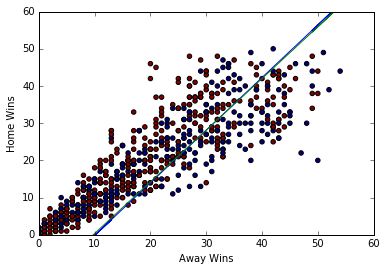

In [84]:
plt.scatter(X2['Away Wins'],X2['Home Wins'],c=Y)
plt.xlabel("Away Wins")
plt.ylabel("Home Wins")
plt.plot(X2['Away Wins'],(model.intercept_ - .5 + model.coef_[0]*X2['Away Wins'])/(-model.coef_[1]),label="Linear Reg. Decison Boundary")
plt.plot(X2['Away Wins'],(modelLog.intercept_ + modelLog.coef_[0][0]*X2['Away Wins'])/(-modelLog.coef_[0][1]),label="Logistic Reg. Decison Boundary")
plt.axis([0,60,0,60])
plt.show()


In [83]:
X_train
#modelLog.coef_

,Away Wins,Home Wins
781,33,23
640,16,20
952,25,34
969,38,30
559,20,21
710,26,22
316,8,12
326,10,9
439,16,11
927,17,28
